## **Setup**

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
!pip install utils
from utils import *

In [4]:
from fastai.vision.all import *

In [5]:
import os
import shutil
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from PIL import Image

from sklearn.metrics import f1_score, accuracy_score

# Load the TensorBoard notebook extension
%load_ext tensorboard

# plot options
# plt.rcParams.update({'font.size': 11})
plt.style.use('fivethirtyeight')

In [6]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
# Set and test path to competition data files
competition_path = 'My Drive/AI For Good - AI Blitz 3/Snake/Data/'
filename = 'train.zip'
assert(os.path.exists(f'{mount_path}/{competition_path}/{filename}'))
print('Drive mounted correctly and data accessible')

Drive mounted correctly and data accessible


# **Functions**



### **Data loading**

In [8]:
# custom copytree because Colab doesn't have the latest version of shutil.copytree which now contains the dirs_exist_ok flag solving this issue
# copied verbatim from https://stackoverflow.com/a/12514470/5991868
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

# Unzip and combine images
Combine the train and validation sets from the competition organizers, we're going to use our own!


In [9]:
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists('/content/All_Data/'):
  os.mkdir('/content/All_Data/')
  os.mkdir('/content/All_Data/non_venomous/')
  os.mkdir('/content/All_Data/venomous/')

  for filename in ['train','val']:
    # create a temporary directory using TemporaryDirectory and context manager and unzip to there
    with TemporaryDirectory() as tmpdirname:
      with ZipFile(f'{mount_path}/{competition_path}/{filename}.zip', 'r') as zip_ref:
        zip_ref.extractall(tmpdirname)
      # copy the data to the All_Data dir
      copytree(f'{tmpdirname}/content/data/{filename}/non_venomous/','/content/All_Data/non_venomous/')
      copytree(f'{tmpdirname}/content/data/{filename}/venomous/','/content/All_Data/venomous/')

In [10]:
def cv_splits(home_dir,num_folds,val_pct,truly_random):
  # returns a dictionary[fold_num][train or val][venom] : list of images
  # eg cvdict[0]['train']['venomous']
  cvdict={key:{'train':{},'val':{}} for key in range(num_folds)}

  assert(val_pct<=(1/num_folds))

  if truly_random:
    rng = np.random.RandomState() # random seeding
  else:
    rng = np.random.RandomState(42) # deterministic seeding

  for venom in ['non_venomous','venomous']:
    imgs=np.array(glob.glob(f'{home_dir}{venom}/*.jpg'))
    # shuffle the image array. NOTE all the randomness in the train-val split comes from this shuffle
    rng.shuffle(imgs)

    # size of the fold
    foldsz=np.floor(len(imgs)/num_folds).astype(int)
    # how many validation images
    numval=np.floor(val_pct*len(imgs)).astype(int)

    for cvfold in range(num_folds):
      valimgs=imgs[(cvfold*foldsz):(cvfold*foldsz+numval)]
      cvdict[cvfold]['val'][venom]=valimgs
      cvdict[cvfold]['train'][venom]=np.setdiff1d(imgs,valimgs)

  return cvdict

In [11]:
def train_val_dirs(home_dir,cvdict,cur_fold):
  # moves the files in cvdict to a train and val directory

  for trainval in ['train','val']:
    # Delete any existing directory then make a new one
    if os.path.exists(os.path.join(home_dir,trainval+os.sep)):
      shutil.rmtree(os.path.join(home_dir,trainval+os.sep))
    os.mkdir(os.path.join(home_dir,trainval+os.sep))

    for venom in ['non_venomous','venomous']:
      os.mkdir(os.path.join(home_dir,trainval,venom+os.sep))
      for curfile in cvdict[cur_fold][trainval][venom]:
        shutil.copy2(curfile,os.path.join(home_dir,trainval,venom+os.sep)+os.path.basename(curfile))
  return

In [12]:
cvdict=cv_splits('/content/All_Data/',3,0.15,False)

In [13]:
train_val_dirs('/content/',cvdict,0)

In [14]:
print('Training Images')
print('   Danger snek : '+str(len(glob.glob('/content/train/venomous/*.jpg'))))
print('   Safe snek : '+str(len(glob.glob('/content/train/non_venomous/*.jpg'))))
print('Validation Images')
print('   Danger snek : '+str(len(glob.glob('/content/val/venomous/*.jpg'))))
print('   Safe snek : '+str(len(glob.glob('/content/val/non_venomous/*.jpg'))))

Training Images
   Danger snek : 22544
   Safe snek : 28193
Validation Images
   Danger snek : 3978
   Safe snek : 4975


# Model setup

In [35]:
dls = ImageDataLoaders.from_folder('/content/',train='train', valid='val',item_tfms=Resize(460),
                                   batch_tfms=aug_transforms(flip_vert=True, max_rotate=45.0, size=224))

In [36]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy],cbs=[ShowGraphCallback()])

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=3.0199516913853586e-05)

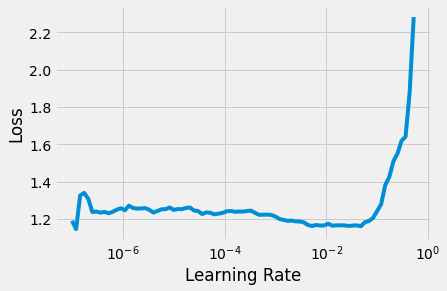

In [37]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.589796,0.527780,0.726237,06:06
1,0.552102,0.493280,0.753044,06:10
2,0.519082,0.458658,0.776164,06:08
3,0.495909,0.444352,0.787892,06:11
4,0.464108,0.430685,0.792807,06:10
5,0.464865,0.410561,0.801296,06:17
6,0.457363,0.411338,0.807327,06:17
7,0.459706,0.418714,0.801296,06:14
8,0.448901,0.418377,0.800290,06:13
9,0.439280,0.400137,0.807997,06:14


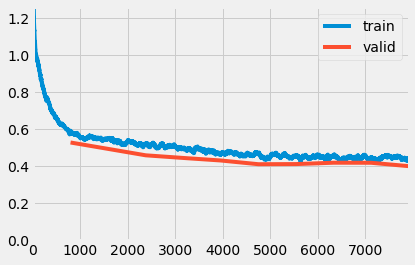

epoch,train_loss,valid_loss,accuracy,time
0,0.452117,0.446639,0.785435,06:32
1,0.469196,0.445656,0.782419,06:34
2,0.442316,0.427173,0.793477,06:27
3,0.423887,0.404213,0.808667,06:31
4,0.392102,0.372444,0.826762,06:35
5,0.360685,0.356436,0.836256,06:38
6,0.330141,0.336731,0.846309,06:34
7,0.323302,0.332882,0.852340,06:34


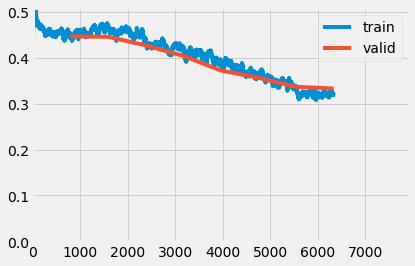

In [ ]:
learn.fine_tune(freeze_epochs=10, epochs=10, base_lr=1e-2)